# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [170]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

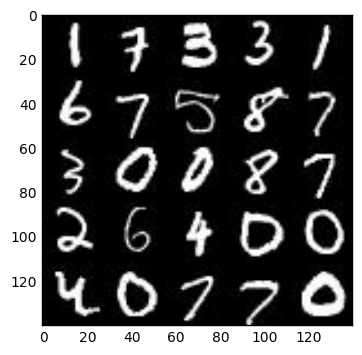

In [171]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

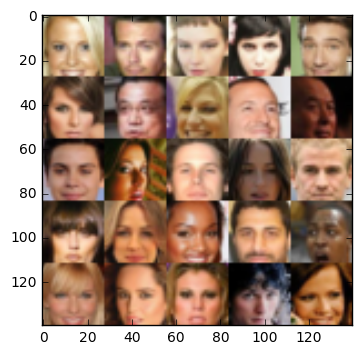

In [172]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [173]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [174]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name = 'learning_rate' )
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [188]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.05
    keep_prob = 0.5
    with tf.variable_scope('discriminator', reuse = reuse):
        
        x1 = tf.layers.conv2d(images,
                              64, 
                              5, 
                              strides = 2, 
                              padding = 'same', 
                              kernel_initializer= tf.contrib.layers.xavier_initializer())
        r1 = tf.maximum( alpha * x1, x1)

        
        x2 = tf.layers.conv2d(r1, 
                              128, 
                              5, 
                              strides = 2, 
                              padding = 'same', 
                              kernel_initializer= tf.contrib.layers.xavier_initializer())
        
        bn2 = tf.layers.batch_normalization(x2, training = True)
        r2 = tf.maximum( alpha * bn2, bn2)
        d2 = tf.nn.dropout(r2, keep_prob = keep_prob)
        x3 = tf.layers.conv2d(r2, 
                              256,
                              5, 
                              strides = 2, 
                              padding = 'same', 
                              kernel_initializer= tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training = True)
        r3 = tf.maximum( alpha * bn3, bn3)
        d3 = tf.nn.dropout(r3, keep_prob = keep_prob)
        
        flat = tf.reshape(r3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [190]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.05
    keep_prob = 0.5
    with tf.variable_scope( 'generator', reuse = not is_train):
        
        x1 = tf.layers.dense(z, 7*7*1024)
        
        #reshape for conv stack
        x1 = tf.reshape(x1, [-1, 7, 7, 1024])
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum( alpha * x1, x1)
        
        #First Layer
        x2 = tf.layers.conv2d_transpose(x1, 
                                        512, 
                                        5, 
                                        strides = 2, 
                                        padding = 'same',
                                        kernel_initializer= tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum( alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob = keep_prob)
        
        x3 = tf.layers.conv2d_transpose(x2, 
                                        256, 
                                        5, 
                                        strides = 2, 
                                        padding = 'same',
                                        kernel_initializer= tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum( alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob = keep_prob)
        
        """
        x4 = tf.layers.conv2d_transpose(x3, 
                                        128, 
                                        5, 
                                        strides = 2, 
                                        padding = 'same', 
                                        kernel_initializer= tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training = is_train)
        x4 = tf.maximum( alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob = keep_prob)
        
        x5 = tf.layers.conv2d_transpose(x4, 
                                        56, 
                                        5, 
                                        strides = 2, 
                                        padding = 'same', 
                                        kernel_initializer= tf.contrib.layers.xavier_initializer())
        x5 = tf.layers.batch_normalization(x5, training = is_train)
        x5 = tf.maximum( alpha * x5, x5)
        x5 = tf.nn.dropout(x5, keep_prob = keep_prob)
        """
        
        logits = tf.layers.conv2d_transpose(x3, 
                                            out_channel_dim, 
                                            5, 
                                            strides = 1, 
                                            padding = 'same', 
                                            kernel_initializer= tf.contrib.layers.xavier_initializer())
        #logits = tf.image.resize_images(logits, (28, 28))
        logits = tf.tanh(logits)
    return logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [191]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(images = input_real)
    d_model_fake, d_logits_fake = discriminator(images = g_model, reuse = True)
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                                        labels = tf.ones_like(d_model_real)*(1-smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                        labels = tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                   labels = tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [192]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 =beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [193]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [194]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver(var_list = g_vars)
    steps = 0
   
    if (data_image_mode == "L"):
        out_channel_dim = 1
    else:
        out_channel_dim = 3
        
    print_every = 10
    
    show_every = 100
    samples, losses = [],[]
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], 
                                                       data_shape[2], 
                                                       data_shape[3], 
                                                       z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(inputs_real, 
                                inputs_z, 
                                out_channel_dim)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_images = batch_images *2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images,
                                               inputs_z: batch_z})       
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, 
                                               inputs_real: batch_images})
                
  
                

                    
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format((epoch_i+1), epoch_count),
                          "Discriminator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    #losses.append((train_loss_d,train_loss_g))
                    
                if steps % show_every == 0:
                    
                    show_generator_output(sess, 9, inputs_z, data_shape[3], 
                                                        data_image_mode)
                    
                    
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4743 Generator Loss: 2.6022
Epoch 1/2... Discriminator Loss: 0.4203 Generator Loss: 4.9999
Epoch 1/2... Discriminator Loss: 0.9878 Generator Loss: 4.9275
Epoch 1/2... Discriminator Loss: 0.8826 Generator Loss: 2.1009
Epoch 1/2... Discriminator Loss: 0.4908 Generator Loss: 3.0117
Epoch 1/2... Discriminator Loss: 0.4922 Generator Loss: 3.2628
Epoch 1/2... Discriminator Loss: 1.6011 Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 0.9208 Generator Loss: 2.5717
Epoch 1/2... Discriminator Loss: 0.7944 Generator Loss: 3.0558
Epoch 1/2... Discriminator Loss: 0.7472 Generator Loss: 1.6055


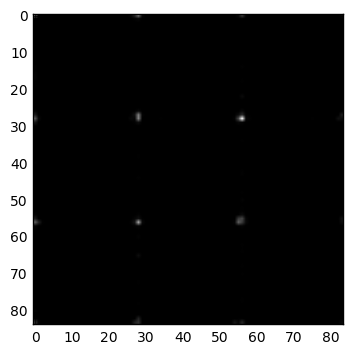

Epoch 1/2... Discriminator Loss: 1.1873 Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 0.9277 Generator Loss: 1.0095
Epoch 1/2... Discriminator Loss: 0.9060 Generator Loss: 1.1559
Epoch 1/2... Discriminator Loss: 0.9124 Generator Loss: 1.3473
Epoch 1/2... Discriminator Loss: 1.2283 Generator Loss: 3.0206
Epoch 1/2... Discriminator Loss: 0.9082 Generator Loss: 0.9352
Epoch 1/2... Discriminator Loss: 0.6487 Generator Loss: 1.8044
Epoch 1/2... Discriminator Loss: 0.5958 Generator Loss: 2.1095
Epoch 1/2... Discriminator Loss: 0.7775 Generator Loss: 1.8597
Epoch 1/2... Discriminator Loss: 1.2472 Generator Loss: 0.6150


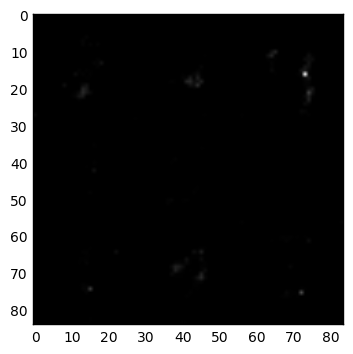

Epoch 1/2... Discriminator Loss: 0.8784 Generator Loss: 1.9108
Epoch 1/2... Discriminator Loss: 0.9944 Generator Loss: 0.9383
Epoch 1/2... Discriminator Loss: 0.9196 Generator Loss: 1.4011
Epoch 1/2... Discriminator Loss: 1.0095 Generator Loss: 0.9969
Epoch 1/2... Discriminator Loss: 1.7443 Generator Loss: 0.3551
Epoch 1/2... Discriminator Loss: 1.0103 Generator Loss: 0.9159
Epoch 1/2... Discriminator Loss: 0.8824 Generator Loss: 1.6244
Epoch 1/2... Discriminator Loss: 0.9871 Generator Loss: 1.2034
Epoch 1/2... Discriminator Loss: 1.0168 Generator Loss: 0.9932
Epoch 1/2... Discriminator Loss: 0.7912 Generator Loss: 1.5423


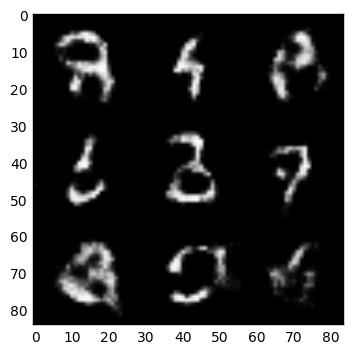

Epoch 1/2... Discriminator Loss: 0.9478 Generator Loss: 2.0173
Epoch 1/2... Discriminator Loss: 1.0778 Generator Loss: 0.8660
Epoch 1/2... Discriminator Loss: 0.9272 Generator Loss: 1.4484
Epoch 1/2... Discriminator Loss: 0.9329 Generator Loss: 1.4874
Epoch 1/2... Discriminator Loss: 1.0203 Generator Loss: 0.8947
Epoch 1/2... Discriminator Loss: 0.9078 Generator Loss: 1.7695
Epoch 1/2... Discriminator Loss: 0.8530 Generator Loss: 1.5106
Epoch 1/2... Discriminator Loss: 0.9797 Generator Loss: 2.1151
Epoch 1/2... Discriminator Loss: 0.9497 Generator Loss: 1.4453
Epoch 1/2... Discriminator Loss: 1.0248 Generator Loss: 1.0401


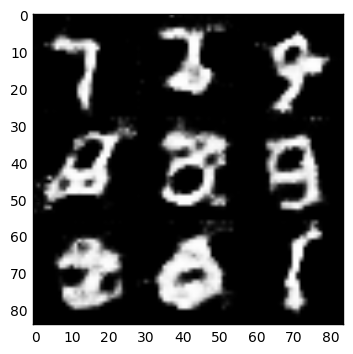

Epoch 1/2... Discriminator Loss: 1.2681 Generator Loss: 0.6275
Epoch 1/2... Discriminator Loss: 0.9497 Generator Loss: 1.5258
Epoch 1/2... Discriminator Loss: 0.8781 Generator Loss: 1.9111
Epoch 1/2... Discriminator Loss: 0.8836 Generator Loss: 1.5055
Epoch 1/2... Discriminator Loss: 0.9663 Generator Loss: 1.1587
Epoch 1/2... Discriminator Loss: 1.1781 Generator Loss: 0.6664
Epoch 1/2... Discriminator Loss: 0.8896 Generator Loss: 1.3736
Epoch 1/2... Discriminator Loss: 0.9803 Generator Loss: 1.7770
Epoch 1/2... Discriminator Loss: 0.9794 Generator Loss: 1.0086
Epoch 1/2... Discriminator Loss: 1.0266 Generator Loss: 0.8854


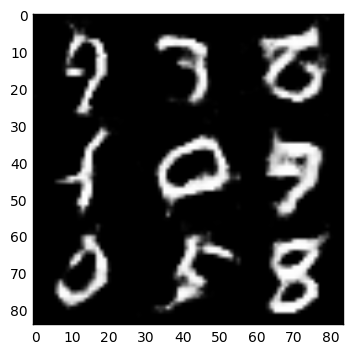

Epoch 1/2... Discriminator Loss: 0.9576 Generator Loss: 1.1775
Epoch 1/2... Discriminator Loss: 1.1035 Generator Loss: 2.5019
Epoch 1/2... Discriminator Loss: 0.9940 Generator Loss: 1.7308
Epoch 1/2... Discriminator Loss: 1.2284 Generator Loss: 0.6209
Epoch 1/2... Discriminator Loss: 1.1719 Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 0.9493 Generator Loss: 1.6956
Epoch 1/2... Discriminator Loss: 0.9480 Generator Loss: 1.0588
Epoch 1/2... Discriminator Loss: 0.9060 Generator Loss: 1.2168
Epoch 1/2... Discriminator Loss: 0.8676 Generator Loss: 1.2905
Epoch 1/2... Discriminator Loss: 0.8914 Generator Loss: 1.4445


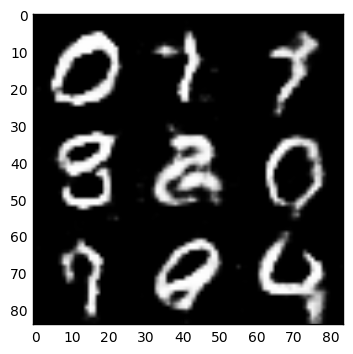

Epoch 1/2... Discriminator Loss: 0.9294 Generator Loss: 1.1428
Epoch 1/2... Discriminator Loss: 1.0184 Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 0.9691 Generator Loss: 1.2367
Epoch 1/2... Discriminator Loss: 0.9477 Generator Loss: 1.3738
Epoch 1/2... Discriminator Loss: 0.9111 Generator Loss: 1.4547
Epoch 1/2... Discriminator Loss: 1.0733 Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.1485 Generator Loss: 2.1588
Epoch 1/2... Discriminator Loss: 0.9313 Generator Loss: 1.5370
Epoch 1/2... Discriminator Loss: 1.2854 Generator Loss: 0.6371
Epoch 1/2... Discriminator Loss: 0.9585 Generator Loss: 1.9665


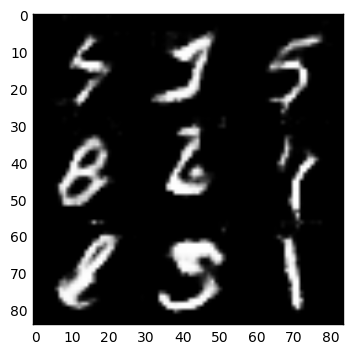

Epoch 1/2... Discriminator Loss: 0.9072 Generator Loss: 1.5871
Epoch 1/2... Discriminator Loss: 0.8961 Generator Loss: 1.2704
Epoch 1/2... Discriminator Loss: 1.7244 Generator Loss: 0.3922
Epoch 1/2... Discriminator Loss: 1.0318 Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 1.0154 Generator Loss: 0.8814
Epoch 1/2... Discriminator Loss: 0.9802 Generator Loss: 1.0534
Epoch 1/2... Discriminator Loss: 0.8670 Generator Loss: 1.3679
Epoch 1/2... Discriminator Loss: 0.8492 Generator Loss: 1.2366
Epoch 1/2... Discriminator Loss: 0.8494 Generator Loss: 1.0470
Epoch 1/2... Discriminator Loss: 0.8663 Generator Loss: 1.4965


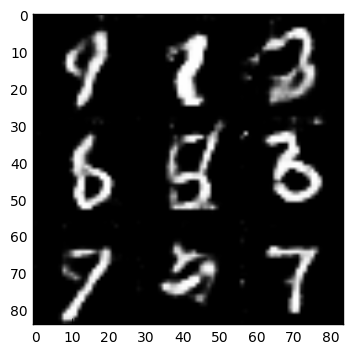

Epoch 1/2... Discriminator Loss: 0.9076 Generator Loss: 1.0887
Epoch 1/2... Discriminator Loss: 0.8790 Generator Loss: 1.5746
Epoch 1/2... Discriminator Loss: 0.9458 Generator Loss: 1.1636
Epoch 1/2... Discriminator Loss: 0.9238 Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 0.9089 Generator Loss: 1.1813
Epoch 1/2... Discriminator Loss: 1.0255 Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 0.8728 Generator Loss: 1.8398
Epoch 1/2... Discriminator Loss: 0.8757 Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 1.0957 Generator Loss: 2.2061
Epoch 1/2... Discriminator Loss: 1.0985 Generator Loss: 0.7884


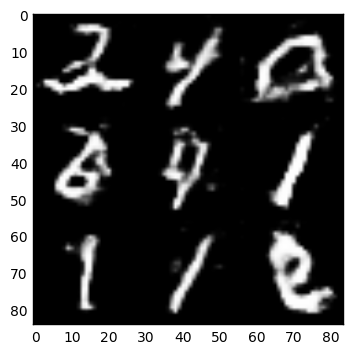

Epoch 1/2... Discriminator Loss: 0.8382 Generator Loss: 1.7997
Epoch 1/2... Discriminator Loss: 1.1432 Generator Loss: 2.3298
Epoch 1/2... Discriminator Loss: 0.9712 Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 1.0369 Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 0.8313 Generator Loss: 1.8359
Epoch 2/2... Discriminator Loss: 0.7541 Generator Loss: 1.4648
Epoch 2/2... Discriminator Loss: 0.9109 Generator Loss: 1.7645
Epoch 2/2... Discriminator Loss: 0.8725 Generator Loss: 1.1258
Epoch 2/2... Discriminator Loss: 0.8692 Generator Loss: 1.0830
Epoch 2/2... Discriminator Loss: 1.0720 Generator Loss: 0.8313


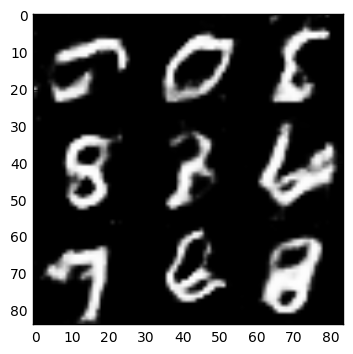

Epoch 2/2... Discriminator Loss: 0.9878 Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 1.4011 Generator Loss: 0.5584
Epoch 2/2... Discriminator Loss: 0.8554 Generator Loss: 1.2230
Epoch 2/2... Discriminator Loss: 0.8196 Generator Loss: 1.7076
Epoch 2/2... Discriminator Loss: 0.8853 Generator Loss: 1.2750
Epoch 2/2... Discriminator Loss: 0.8147 Generator Loss: 1.3332
Epoch 2/2... Discriminator Loss: 0.8719 Generator Loss: 1.8228
Epoch 2/2... Discriminator Loss: 0.9280 Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 0.9984 Generator Loss: 0.8074
Epoch 2/2... Discriminator Loss: 0.8296 Generator Loss: 1.2755


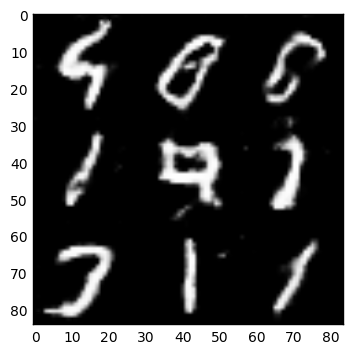

Epoch 2/2... Discriminator Loss: 0.8410 Generator Loss: 1.3021
Epoch 2/2... Discriminator Loss: 0.9574 Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 1.1478 Generator Loss: 0.8880
Epoch 2/2... Discriminator Loss: 0.7997 Generator Loss: 1.6995
Epoch 2/2... Discriminator Loss: 0.8068 Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 0.8119 Generator Loss: 1.2658
Epoch 2/2... Discriminator Loss: 0.8988 Generator Loss: 1.2043
Epoch 2/2... Discriminator Loss: 1.1523 Generator Loss: 0.7641
Epoch 2/2... Discriminator Loss: 0.7208 Generator Loss: 1.5992
Epoch 2/2... Discriminator Loss: 1.1536 Generator Loss: 2.7574


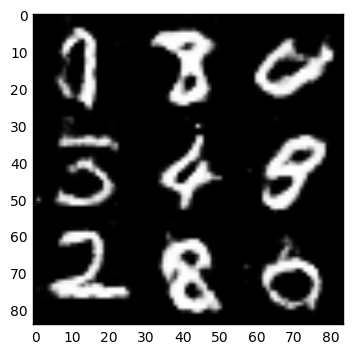

Epoch 2/2... Discriminator Loss: 0.8059 Generator Loss: 1.5454
Epoch 2/2... Discriminator Loss: 0.8423 Generator Loss: 1.3214
Epoch 2/2... Discriminator Loss: 1.1830 Generator Loss: 2.0404
Epoch 2/2... Discriminator Loss: 0.9810 Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 0.8079 Generator Loss: 1.6514
Epoch 2/2... Discriminator Loss: 0.9046 Generator Loss: 2.2426
Epoch 2/2... Discriminator Loss: 0.8708 Generator Loss: 1.0914
Epoch 2/2... Discriminator Loss: 0.9332 Generator Loss: 2.3664
Epoch 2/2... Discriminator Loss: 0.9400 Generator Loss: 0.9451
Epoch 2/2... Discriminator Loss: 0.6990 Generator Loss: 1.8064


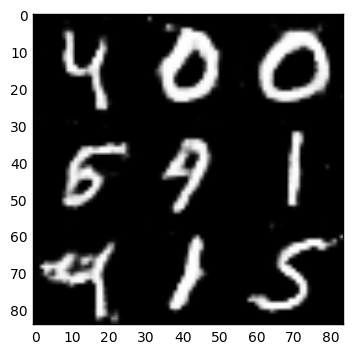

Epoch 2/2... Discriminator Loss: 0.8368 Generator Loss: 2.1642
Epoch 2/2... Discriminator Loss: 0.9524 Generator Loss: 2.0716
Epoch 2/2... Discriminator Loss: 1.2260 Generator Loss: 0.5894
Epoch 2/2... Discriminator Loss: 0.8040 Generator Loss: 1.5216
Epoch 2/2... Discriminator Loss: 3.3876 Generator Loss: 5.4078
Epoch 2/2... Discriminator Loss: 0.9959 Generator Loss: 1.6024
Epoch 2/2... Discriminator Loss: 0.8398 Generator Loss: 1.2550
Epoch 2/2... Discriminator Loss: 0.8056 Generator Loss: 1.3626
Epoch 2/2... Discriminator Loss: 0.7438 Generator Loss: 2.0235
Epoch 2/2... Discriminator Loss: 0.8387 Generator Loss: 1.0773


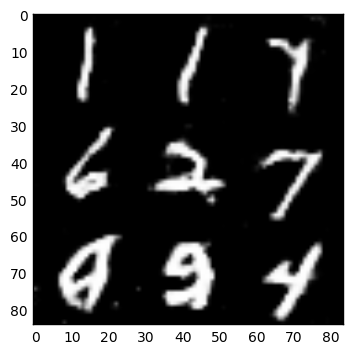

Epoch 2/2... Discriminator Loss: 0.7001 Generator Loss: 1.8846
Epoch 2/2... Discriminator Loss: 0.7594 Generator Loss: 1.5702
Epoch 2/2... Discriminator Loss: 0.7761 Generator Loss: 1.5379
Epoch 2/2... Discriminator Loss: 0.7802 Generator Loss: 1.3339
Epoch 2/2... Discriminator Loss: 0.7465 Generator Loss: 1.6262
Epoch 2/2... Discriminator Loss: 0.8031 Generator Loss: 1.4024
Epoch 2/2... Discriminator Loss: 0.8757 Generator Loss: 1.0900
Epoch 2/2... Discriminator Loss: 0.7369 Generator Loss: 1.3817
Epoch 2/2... Discriminator Loss: 0.7596 Generator Loss: 1.2806
Epoch 2/2... Discriminator Loss: 0.6635 Generator Loss: 1.5757


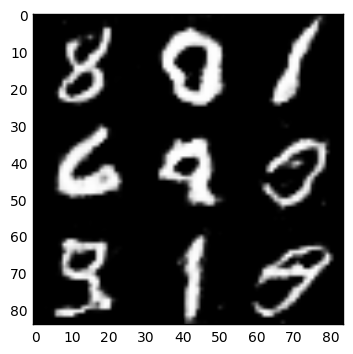

Epoch 2/2... Discriminator Loss: 0.8091 Generator Loss: 1.1498
Epoch 2/2... Discriminator Loss: 0.7141 Generator Loss: 1.6973
Epoch 2/2... Discriminator Loss: 0.6215 Generator Loss: 1.7523
Epoch 2/2... Discriminator Loss: 0.6579 Generator Loss: 1.7755
Epoch 2/2... Discriminator Loss: 0.8003 Generator Loss: 1.3363
Epoch 2/2... Discriminator Loss: 0.8876 Generator Loss: 1.1052
Epoch 2/2... Discriminator Loss: 0.6990 Generator Loss: 1.5081
Epoch 2/2... Discriminator Loss: 1.8175 Generator Loss: 0.3450
Epoch 2/2... Discriminator Loss: 0.7997 Generator Loss: 1.3428
Epoch 2/2... Discriminator Loss: 0.7815 Generator Loss: 1.3121


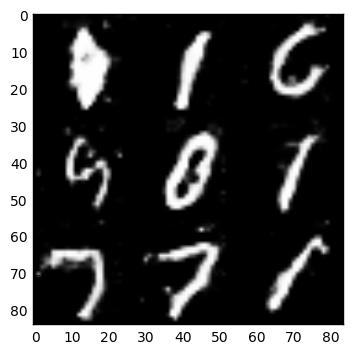

Epoch 2/2... Discriminator Loss: 0.8068 Generator Loss: 2.2450
Epoch 2/2... Discriminator Loss: 0.8326 Generator Loss: 2.2838
Epoch 2/2... Discriminator Loss: 0.7777 Generator Loss: 1.2737
Epoch 2/2... Discriminator Loss: 0.9391 Generator Loss: 1.1388
Epoch 2/2... Discriminator Loss: 0.7866 Generator Loss: 2.4256
Epoch 2/2... Discriminator Loss: 1.2552 Generator Loss: 0.6395
Epoch 2/2... Discriminator Loss: 1.0550 Generator Loss: 1.1130
Epoch 2/2... Discriminator Loss: 0.8543 Generator Loss: 1.3533
Epoch 2/2... Discriminator Loss: 0.7865 Generator Loss: 1.8369
Epoch 2/2... Discriminator Loss: 0.8537 Generator Loss: 1.5981


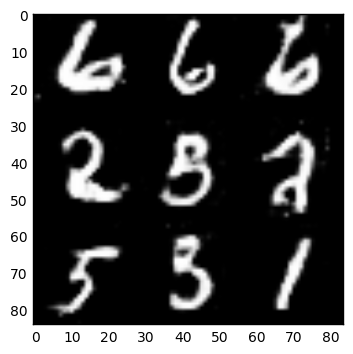

Epoch 2/2... Discriminator Loss: 1.2521 Generator Loss: 0.7315
Epoch 2/2... Discriminator Loss: 0.7683 Generator Loss: 2.0855
Epoch 2/2... Discriminator Loss: 0.6811 Generator Loss: 1.7927
Epoch 2/2... Discriminator Loss: 0.6532 Generator Loss: 1.6732
Epoch 2/2... Discriminator Loss: 0.7395 Generator Loss: 1.9450
Epoch 2/2... Discriminator Loss: 0.8357 Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.6146 Generator Loss: 1.7546
Epoch 2/2... Discriminator Loss: 1.0163 Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 0.7547 Generator Loss: 1.6360
Epoch 2/2... Discriminator Loss: 0.8016 Generator Loss: 1.3910


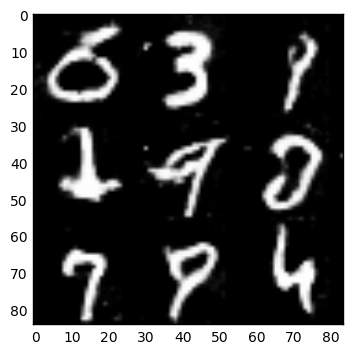

Epoch 2/2... Discriminator Loss: 0.8460 Generator Loss: 2.1785
Epoch 2/2... Discriminator Loss: 0.7289 Generator Loss: 1.6066
Epoch 2/2... Discriminator Loss: 0.6276 Generator Loss: 1.7953
Epoch 2/2... Discriminator Loss: 0.5883 Generator Loss: 1.9641
Epoch 2/2... Discriminator Loss: 0.6135 Generator Loss: 2.3903
Epoch 2/2... Discriminator Loss: 0.9509 Generator Loss: 2.6121
Epoch 2/2... Discriminator Loss: 0.7201 Generator Loss: 1.6391


In [195]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4390 Generator Loss: 3.1110
Epoch 1/1... Discriminator Loss: 0.4605 Generator Loss: 2.5962
Epoch 1/1... Discriminator Loss: 0.3991 Generator Loss: 3.7301
Epoch 1/1... Discriminator Loss: 1.5187 Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.8508 Generator Loss: 6.2925
Epoch 1/1... Discriminator Loss: 0.6430 Generator Loss: 2.0834
Epoch 1/1... Discriminator Loss: 0.5470 Generator Loss: 2.3391
Epoch 1/1... Discriminator Loss: 0.4480 Generator Loss: 2.7771
Epoch 1/1... Discriminator Loss: 0.4099 Generator Loss: 3.2364
Epoch 1/1... Discriminator Loss: 0.4243 Generator Loss: 3.8721


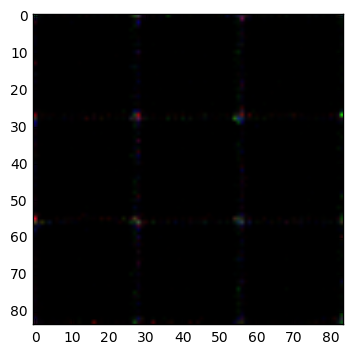

Epoch 1/1... Discriminator Loss: 0.4177 Generator Loss: 2.9992
Epoch 1/1... Discriminator Loss: 0.3878 Generator Loss: 4.5475
Epoch 1/1... Discriminator Loss: 0.4952 Generator Loss: 2.3670
Epoch 1/1... Discriminator Loss: 0.5472 Generator Loss: 2.1062
Epoch 1/1... Discriminator Loss: 0.5494 Generator Loss: 4.4945
Epoch 1/1... Discriminator Loss: 0.4378 Generator Loss: 3.0316
Epoch 1/1... Discriminator Loss: 0.4111 Generator Loss: 3.5595
Epoch 1/1... Discriminator Loss: 0.5162 Generator Loss: 2.1519
Epoch 1/1... Discriminator Loss: 0.4665 Generator Loss: 2.8964
Epoch 1/1... Discriminator Loss: 0.4449 Generator Loss: 3.1458


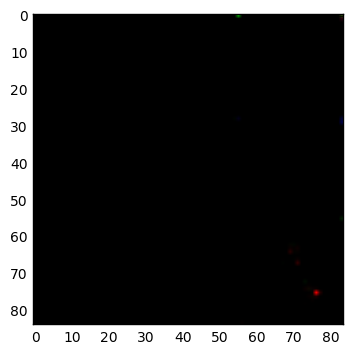

Epoch 1/1... Discriminator Loss: 1.0886 Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 2.0343 Generator Loss: 0.2673
Epoch 1/1... Discriminator Loss: 0.7793 Generator Loss: 1.3655
Epoch 1/1... Discriminator Loss: 0.6028 Generator Loss: 2.2471
Epoch 1/1... Discriminator Loss: 0.7486 Generator Loss: 3.6294
Epoch 1/1... Discriminator Loss: 0.9373 Generator Loss: 4.2761
Epoch 1/1... Discriminator Loss: 1.2136 Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 0.7829 Generator Loss: 1.3705
Epoch 1/1... Discriminator Loss: 0.9562 Generator Loss: 2.5370
Epoch 1/1... Discriminator Loss: 1.5678 Generator Loss: 4.5929


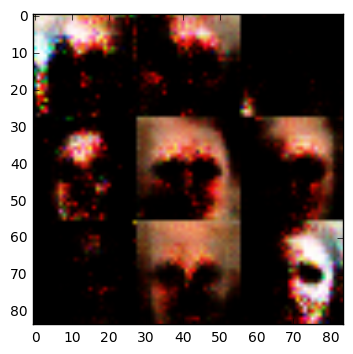

Epoch 1/1... Discriminator Loss: 0.5951 Generator Loss: 2.4658
Epoch 1/1... Discriminator Loss: 1.2657 Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 0.9225 Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 0.6972 Generator Loss: 2.0813
Epoch 1/1... Discriminator Loss: 0.9185 Generator Loss: 2.1930
Epoch 1/1... Discriminator Loss: 0.8332 Generator Loss: 1.7860
Epoch 1/1... Discriminator Loss: 1.7410 Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 0.8734 Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 1.1049 Generator Loss: 1.5455
Epoch 1/1... Discriminator Loss: 0.7588 Generator Loss: 1.4733


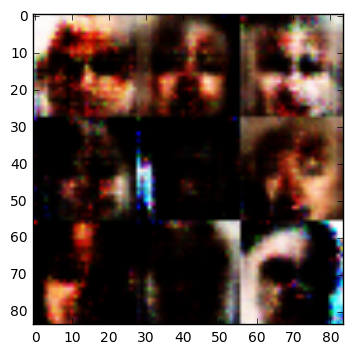

Epoch 1/1... Discriminator Loss: 1.6027 Generator Loss: 3.0049
Epoch 1/1... Discriminator Loss: 1.6187 Generator Loss: 0.3771
Epoch 1/1... Discriminator Loss: 0.9217 Generator Loss: 1.4385
Epoch 1/1... Discriminator Loss: 0.7377 Generator Loss: 1.9377
Epoch 1/1... Discriminator Loss: 0.9056 Generator Loss: 1.3718
Epoch 1/1... Discriminator Loss: 1.0305 Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 0.6810 Generator Loss: 1.6871
Epoch 1/1... Discriminator Loss: 0.9374 Generator Loss: 1.3378
Epoch 1/1... Discriminator Loss: 1.0622 Generator Loss: 1.3546
Epoch 1/1... Discriminator Loss: 0.8614 Generator Loss: 1.3266


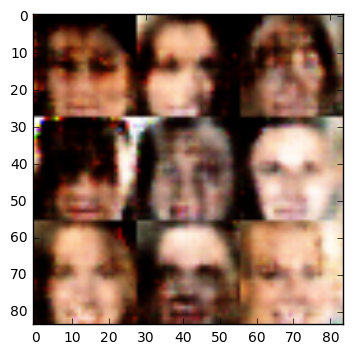

Epoch 1/1... Discriminator Loss: 1.2284 Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 0.9737 Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.1875 Generator Loss: 3.0150
Epoch 1/1... Discriminator Loss: 0.9062 Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 0.9489 Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 1.3476 Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.1516 Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 0.9215 Generator Loss: 1.2988
Epoch 1/1... Discriminator Loss: 1.0570 Generator Loss: 1.4986
Epoch 1/1... Discriminator Loss: 1.0239 Generator Loss: 1.0255


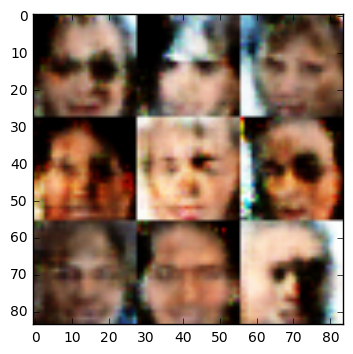

Epoch 1/1... Discriminator Loss: 1.0542 Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 0.9626 Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 1.2129 Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 0.9881 Generator Loss: 1.7549
Epoch 1/1... Discriminator Loss: 0.9330 Generator Loss: 1.6847
Epoch 1/1... Discriminator Loss: 1.0578 Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.1432 Generator Loss: 1.9276
Epoch 1/1... Discriminator Loss: 0.8827 Generator Loss: 1.1851
Epoch 1/1... Discriminator Loss: 0.8955 Generator Loss: 1.2422
Epoch 1/1... Discriminator Loss: 1.1572 Generator Loss: 0.7520


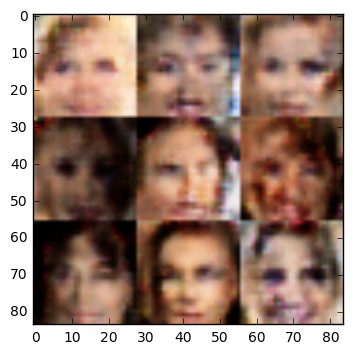

Epoch 1/1... Discriminator Loss: 0.7716 Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 0.9680 Generator Loss: 1.5625
Epoch 1/1... Discriminator Loss: 1.2388 Generator Loss: 1.6300
Epoch 1/1... Discriminator Loss: 1.4105 Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.2397 Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 0.8357 Generator Loss: 1.6586
Epoch 1/1... Discriminator Loss: 0.9192 Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 0.9681 Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.1012 Generator Loss: 2.0968
Epoch 1/1... Discriminator Loss: 1.0338 Generator Loss: 1.1210


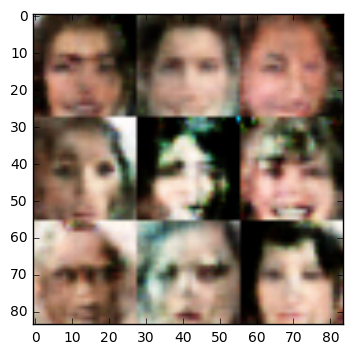

Epoch 1/1... Discriminator Loss: 1.1257 Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 1.0173 Generator Loss: 1.6676
Epoch 1/1... Discriminator Loss: 1.0321 Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.4158 Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 0.9833 Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 1.1407 Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.0295 Generator Loss: 1.4684
Epoch 1/1... Discriminator Loss: 0.9588 Generator Loss: 1.5679
Epoch 1/1... Discriminator Loss: 1.3040 Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.0967 Generator Loss: 0.8104


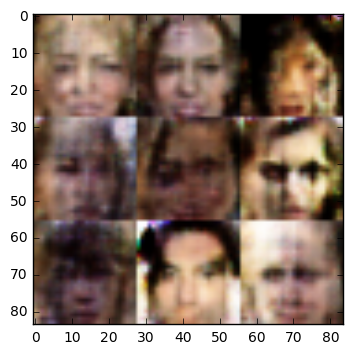

Epoch 1/1... Discriminator Loss: 1.0051 Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.2096 Generator Loss: 1.7609
Epoch 1/1... Discriminator Loss: 1.0674 Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.4913 Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 1.3020 Generator Loss: 1.7062
Epoch 1/1... Discriminator Loss: 1.1015 Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3038 Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.0821 Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3848 Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.1450 Generator Loss: 0.9159


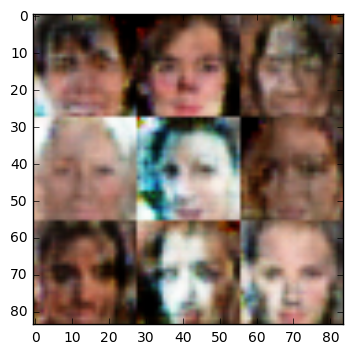

Epoch 1/1... Discriminator Loss: 1.1294 Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.0736 Generator Loss: 1.4140
Epoch 1/1... Discriminator Loss: 1.3409 Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.1821 Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.5159 Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.0478 Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 0.8936 Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 1.0697 Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 0.7777 Generator Loss: 2.6543
Epoch 1/1... Discriminator Loss: 1.2918 Generator Loss: 1.8162


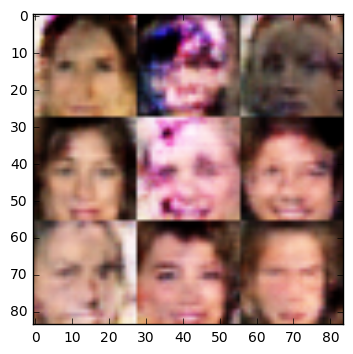

Epoch 1/1... Discriminator Loss: 1.2318 Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.1378 Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.1658 Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.2737 Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.1375 Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 1.0662 Generator Loss: 1.3546
Epoch 1/1... Discriminator Loss: 1.2815 Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.2278 Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.0270 Generator Loss: 1.3972
Epoch 1/1... Discriminator Loss: 1.1825 Generator Loss: 0.9184


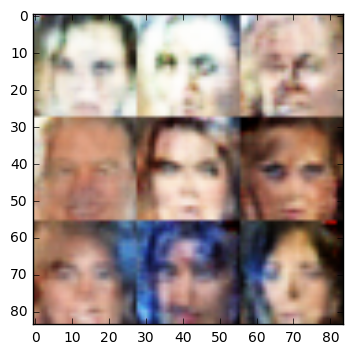

Epoch 1/1... Discriminator Loss: 1.1112 Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 1.1246 Generator Loss: 1.7839
Epoch 1/1... Discriminator Loss: 1.0709 Generator Loss: 1.5202
Epoch 1/1... Discriminator Loss: 1.7181 Generator Loss: 0.3291
Epoch 1/1... Discriminator Loss: 1.1503 Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 0.7239 Generator Loss: 2.1634
Epoch 1/1... Discriminator Loss: 0.9901 Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.0777 Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.2534 Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.2591 Generator Loss: 0.6493


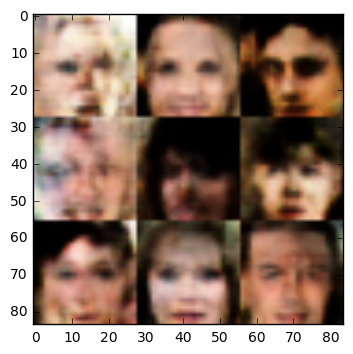

Epoch 1/1... Discriminator Loss: 1.1382 Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.1578 Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.1622 Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 1.2056 Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.2683 Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.0105 Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.1567 Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.2332 Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 1.1091 Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.0345 Generator Loss: 1.2590


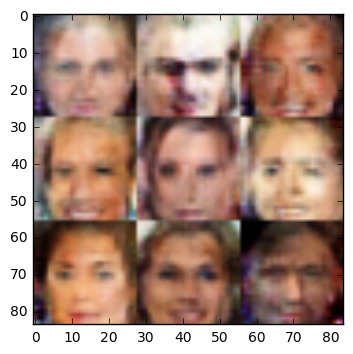

Epoch 1/1... Discriminator Loss: 1.1794 Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 1.1224 Generator Loss: 1.4040
Epoch 1/1... Discriminator Loss: 1.3239 Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.0342 Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 1.3975 Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1970 Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.2816 Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.2521 Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.0038 Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.1653 Generator Loss: 1.0332


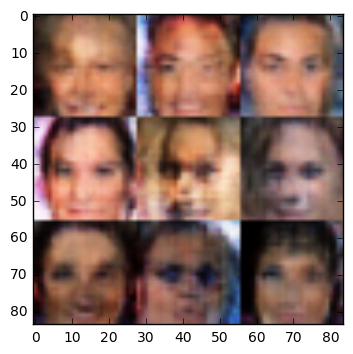

Epoch 1/1... Discriminator Loss: 1.1779 Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 0.9257 Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 1.4153 Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.0378 Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.1625 Generator Loss: 1.0121
Epoch 1/1... Discriminator Loss: 1.1790 Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.1602 Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 1.1361 Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2713 Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 0.7702 Generator Loss: 1.3480


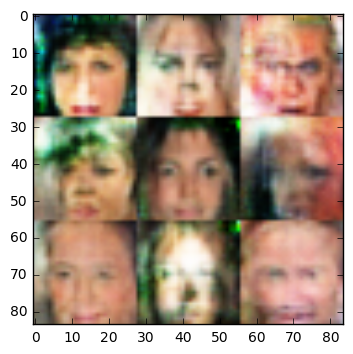

Epoch 1/1... Discriminator Loss: 0.9717 Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 1.2656 Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.1562 Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 1.2072 Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.1744 Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 0.9990 Generator Loss: 1.2107
Epoch 1/1... Discriminator Loss: 1.2928 Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 1.3326 Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.1385 Generator Loss: 1.2688
Epoch 1/1... Discriminator Loss: 0.9359 Generator Loss: 1.5601


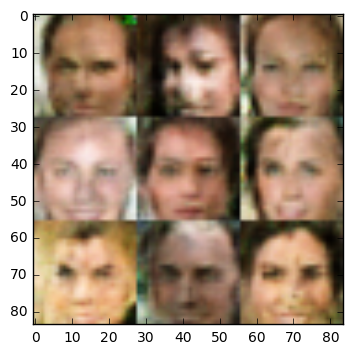

Epoch 1/1... Discriminator Loss: 1.5629 Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.2763 Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.2090 Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.1525 Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.1116 Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.1068 Generator Loss: 1.2383
Epoch 1/1... Discriminator Loss: 1.0238 Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.2430 Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.2552 Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 0.7848 Generator Loss: 1.5497


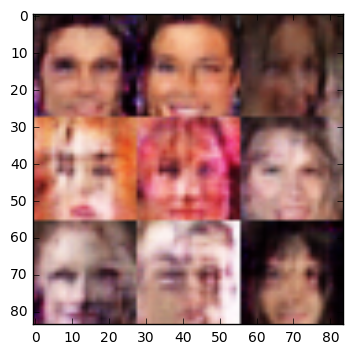

Epoch 1/1... Discriminator Loss: 1.1829 Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 1.3042 Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1852 Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.2778 Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.5281 Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 1.1791 Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3391 Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.4866 Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.1180 Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 1.2273 Generator Loss: 0.8328


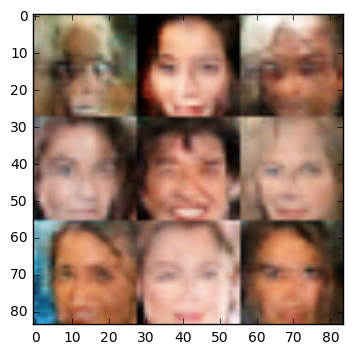

Epoch 1/1... Discriminator Loss: 0.9887 Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 1.0878 Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.2572 Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.2462 Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.1162 Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.2803 Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3511 Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3240 Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.2812 Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.2633 Generator Loss: 0.7268


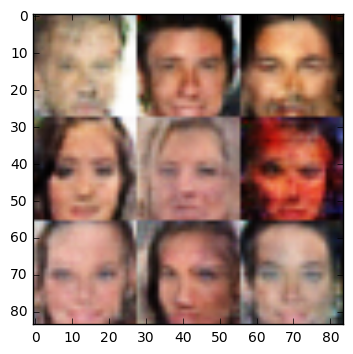

Epoch 1/1... Discriminator Loss: 1.3920 Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.4502 Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.0725 Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 1.2664 Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.1158 Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.2065 Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 0.9895 Generator Loss: 1.5650
Epoch 1/1... Discriminator Loss: 1.1224 Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.2656 Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.1328 Generator Loss: 1.2445


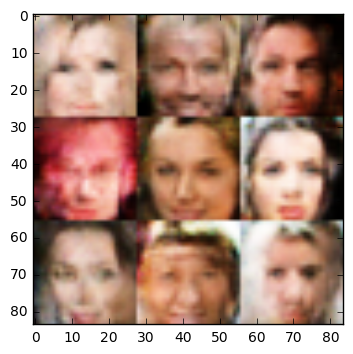

Epoch 1/1... Discriminator Loss: 1.0676 Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.3139 Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.1968 Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 1.1350 Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.3139 Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.1244 Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.2595 Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.1763 Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 1.1599 Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 1.2039 Generator Loss: 0.7764


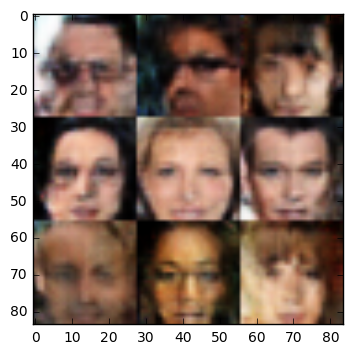

Epoch 1/1... Discriminator Loss: 1.1170 Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.1416 Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.1966 Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.4352 Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3571 Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.1716 Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.1770 Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.1611 Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.3361 Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3375 Generator Loss: 0.6846


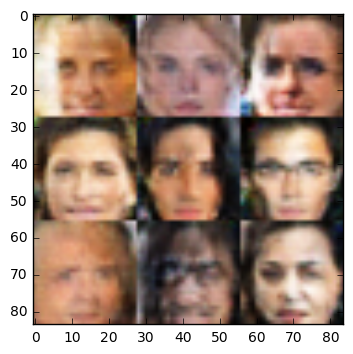

Epoch 1/1... Discriminator Loss: 1.3321 Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.3221 Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.2897 Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.1090 Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.2185 Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 1.3609 Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.1586 Generator Loss: 1.1879
Epoch 1/1... Discriminator Loss: 1.2681 Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.2692 Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.2474 Generator Loss: 0.7649


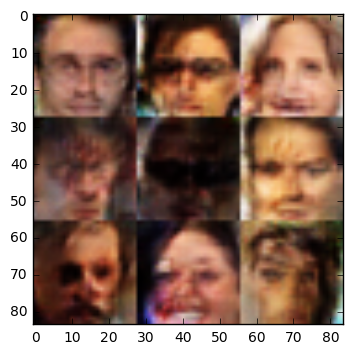

Epoch 1/1... Discriminator Loss: 1.2277 Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.3389 Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.2534 Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.3337 Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.1920 Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.2184 Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.1290 Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.3513 Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.2185 Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.2496 Generator Loss: 0.8004


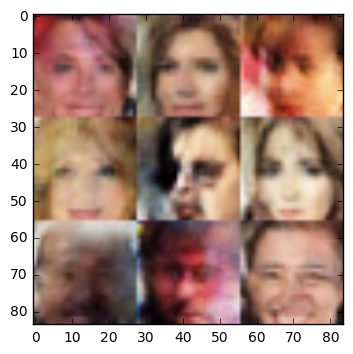

Epoch 1/1... Discriminator Loss: 1.2225 Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.2568 Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.0780 Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.1616 Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3507 Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.1509 Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.2693 Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.3367 Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.1408 Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 1.1424 Generator Loss: 0.8290


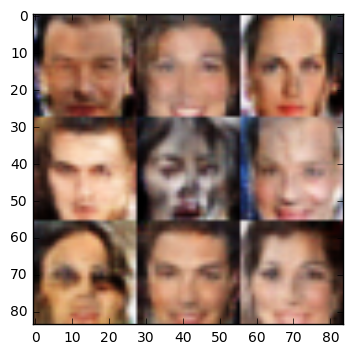

Epoch 1/1... Discriminator Loss: 1.1969 Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.1564 Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.3540 Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.1470 Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.1670 Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.1485 Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.0649 Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.0672 Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 1.0293 Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 1.2785 Generator Loss: 0.8124


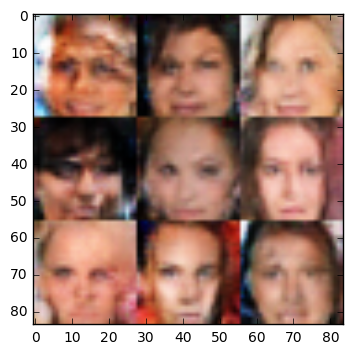

Epoch 1/1... Discriminator Loss: 1.3633 Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.1979 Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.2842 Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3965 Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.2705 Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.4207 Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.4846 Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.1931 Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.2414 Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.2040 Generator Loss: 1.0313


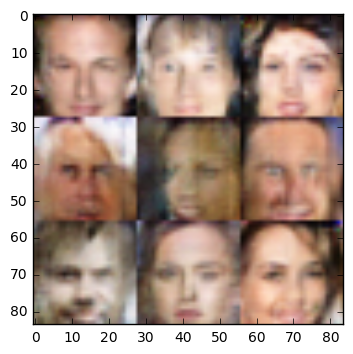

Epoch 1/1... Discriminator Loss: 1.1901 Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.2548 Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.0984 Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.0943 Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 1.2762 Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.2122 Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.1590 Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.1749 Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.1545 Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.1987 Generator Loss: 0.8921


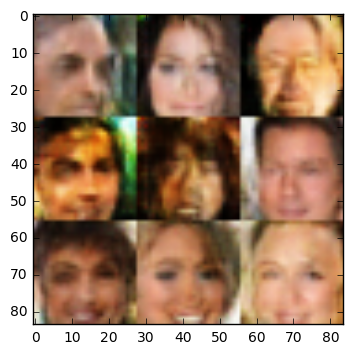

Epoch 1/1... Discriminator Loss: 1.3830 Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.2867 Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.1981 Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.2084 Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.3972 Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.0556 Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 1.3327 Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2836 Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.3428 Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.1246 Generator Loss: 0.9836


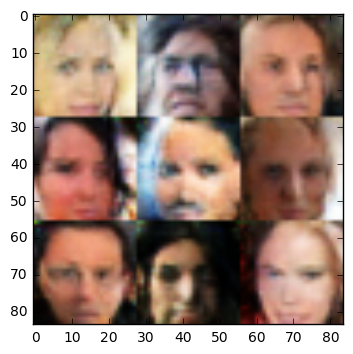

Epoch 1/1... Discriminator Loss: 1.2160 Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.2203 Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.2524 Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.1665 Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.2180 Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.1427 Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.1797 Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.4279 Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.2667 Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3979 Generator Loss: 0.6710


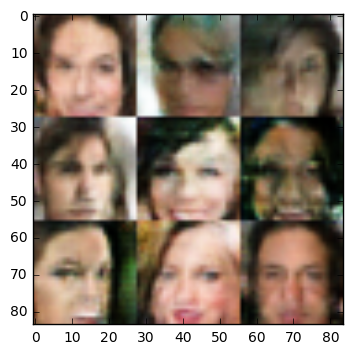

Epoch 1/1... Discriminator Loss: 1.3802 Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.2145 Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.2496 Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.1713 Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.2420 Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.1221 Generator Loss: 0.9216


In [196]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.